<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is a SAM model code **

reference code source:[https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb](http://)

In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install git+https://github.com/huggingface/transformers.git@v4.36.1
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install albumentations

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qnh66k4h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qnh66k4h
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/huggingface/transformers.git (to revision v4.36.1) to /tmp/pip-req-build-sbs0wqoi
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-sbs0wqoi
  Running command git checkout -q 4c920c49503c8c8500deaa7fa84c2d86b864f006
  Resolved https://github.com/huggingface/transformers.git to commit 4c920c49503c8c8500deaa7fa84c2d86b864f006
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filena

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from datasets import Dataset
from PIL import Image
import torch
from transformers import SamModel, SamConfig, SamProcessor
import albumentations as A
from torch.nn.functional import interpolate
from tqdm import tqdm
from statistics import mean
from torch.nn.functional import threshold, normalize
import cv2
from sklearn.metrics import roc_auc_score, roc_curve

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Specify the directories for RGB images and mask labels
image_directory = "/kaggle/input/forest-all/Forest_Deoldify_all/input/train"
label_directory = "/kaggle/input/forest-all/Forest_Deoldify_all/target/train"

# Get a list of all RGB image files in the directory
image_files = [f for f in os.listdir(image_directory) if f.endswith('.tif')]

# Specify the desired size for resizing
target_size = (256, 256)

# Define data augmentation transforms
augmentation_transform1 = A.Compose([
    A.Rotate(limit=(-45, 45), p=1.0),
], p=1.0, is_check_shapes=False)

augmentation_transform2 = A.Compose([
    A.GaussianBlur(blur_limit=(0, 3.0), p=1.0),
], p=1.0, is_check_shapes=False)

augmentation_transform3 = A.Compose([
    A.RandomGamma(p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform4 = A.Compose([
    A.HorizontalFlip(p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform5 = A.Compose([
    A.RandomBrightnessContrast(p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform6 = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform7 = A.Compose([
    A.VerticalFlip(p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform8 = A.Compose([
    A.GaussianBlur(blur_limit=(0, 3.0), p=1.0),
], p=1.0, is_check_shapes=False)

augmentation_transform9 = A.Compose([
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform10 = A.Compose([
    A.GridDistortion(p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform11 = A.Compose([
    A.ElasticTransform(alpha=2, sigma=10, alpha_affine=50, p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform12 = A.Compose([
    A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform13 = A.Compose([
    A.Rotate(limit=(-90, 90), p=1.0),
], p=1.0, is_check_shapes=False)

augmentation_transform14 = A.Compose([
    A.Rotate(limit=(-135, 135), p=1.0),
], p=1.0, is_check_shapes=False)

augmentation_transform15 = A.Compose([
    A.OpticalDistortion(p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform16 = A.Compose([
    A.Cutout(num_holes=4, max_h_size=16, max_w_size=16, p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform17 = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.3, p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform18 = A.Compose([
    A.RandomGamma(gamma_limit=(80, 120), p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform19 = A.Compose([
    A.ElasticTransform(alpha=3, sigma=50, alpha_affine=50, p=1),
], p=1.0, is_check_shapes=False)

augmentation_transform20 = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=1),
], p=1.0, is_check_shapes=False)


augmented_images = []
augmented_masks = []
num = 0
num_0 = 0
num_1 = 0

# Iterate over RGB image files
for image_file in image_files:
    # Read RGB image
    num+=1
    image_path = os.path.join(image_directory, image_file)
    rgb_image = Image.open(image_path)

    # Assume the corresponding mask label file has "_mask" in its name
    mask_file = image_file.replace('input', 'target')
    mask_path = os.path.join(label_directory, mask_file)

    # Read corresponding mask label
    mask_label = tifffile.imread(mask_path)

    # Convert RGB image to grayscale and resize
    grayscale_image = rgb_image.convert("L").resize(target_size)
    if rgb_image.size != target_size:
        mask_label = mask_label.astype(np.uint8)
        mask_label = A.resize(mask_label, height=target_size[0], width=target_size[1])

    mask_label[mask_label > 1] = 2

    mask_label = mask_label.squeeze()
    augmented_images.append(np.array(grayscale_image))
    augmented_masks.append(np.array(mask_label))

    # Apply data augmentation to image and mask
    if np.all(mask_label == 0):
        num_0 += 1
    elif np.all(mask_label == 1):
        num_1+=1
        
        # Define multiple augmentation transforms
        augmentation_transforms = [
            augmentation_transform1,
            augmentation_transform2,
            augmentation_transform3,
            augmentation_transform4,
            augmentation_transform5,
            augmentation_transform6,
            augmentation_transform7,
            augmentation_transform8,
            augmentation_transform9,
            augmentation_transform10,
            augmentation_transform11,
            augmentation_transform12,
            augmentation_transform13,
            augmentation_transform14,
            augmentation_transform15,
            augmentation_transform16,
            augmentation_transform17,
            augmentation_transform18,
            augmentation_transform19,
            augmentation_transform20,
            # Add more augmentation techniques as needed
        ]

        # Apply each augmentation transform and append to the lists
        for transform in augmentation_transforms:
            augmented = transform(image=np.array(grayscale_image), mask=np.array([mask_label]))
            augmented_images.append(augmented['image'])
            augmented_masks.append(augmented['mask'][0])

    else:
        # If mask is not all 0 or 1, apply a single transformation
        augmented = augmentation_transform1(image=np.array(grayscale_image), mask=np.array([mask_label]))
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'][0])


filtered_images = np.array(augmented_images)
filtered_masks = np.array(augmented_masks)

# Print the shapes of the augmented images and masks
print("Augmented Image shape:", filtered_images.shape)
print("Augmented Mask shape:", filtered_masks.shape)

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


(3121, 256, 256)
585
48
Augmented Image shape: (3121, 256, 256)
Augmented Mask shape: (3121, 256, 256)


In [6]:
# Convert NumPy arrays to Pillow images and store in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

In [7]:
dataset = Dataset.from_dict(dataset_dict)
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3121
})

<PIL.PngImagePlugin.PngImageFile image mode=L size=256x256 at 0x78D583DEA4A0>
2


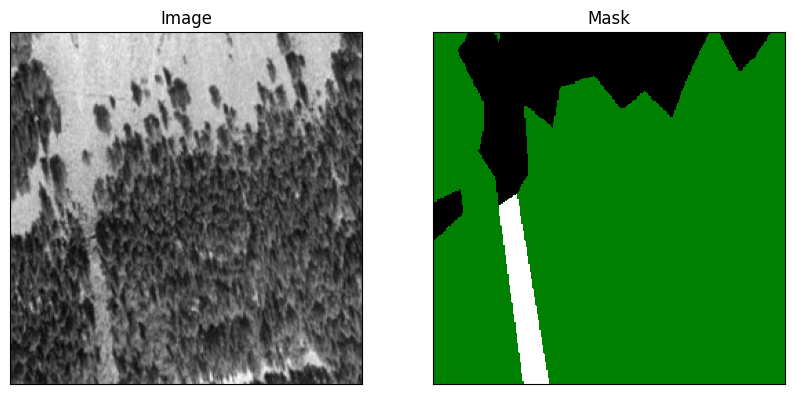

In [8]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
cmap2 = plt.cm.colors.ListedColormap(['black', 'green', 'white'])
print(np.max(example_mask))
axes[1].imshow(example_mask, cmap=cmap2)  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [9]:
def get_bounding_box_image(image):
    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        image = image.mean(axis=2)

    # Threshold the image to create a binary mask
    binary_mask = (image > 0).astype(np.uint8)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box from the first contour
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])

        # Add perturbation to bounding box coordinates
        H, W = image.shape[:2]
        x_min = max(0, x - np.random.randint(0, 20))
        x_max = min(W, x + w + np.random.randint(0, 20))
        y_min = max(0, y - np.random.randint(0, 20))
        y_max = min(H, y + h + np.random.randint(0, 20))
        
        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        # Return a default bounding box if no contours are found
        return [0, 0, 0, 0]

In [10]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box_image(np.array(image))

    # prepare image and prompt for the model
    #inputs = self.processor(image, input_points=input_points, return_tensors="pt")
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [11]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [12]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [13]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [14]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, drop_last=False)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([5, 3, 1024, 1024])
original_sizes torch.Size([5, 2])
reshaped_input_sizes torch.Size([5, 2])
input_boxes torch.Size([5, 1, 4])
ground_truth_mask torch.Size([5, 256, 256])


In [16]:
batch["ground_truth_mask"].shape

torch.Size([5, 256, 256])

In [17]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
         param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [18]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [19]:
def calculate_accuracy(pred_masks, true_masks):
    correct_pixels = torch.eq(pred_masks, true_masks).sum().item()
    total_pixels = true_masks.numel()

    accuracy = correct_pixels / total_pixels
    return accuracy

In [20]:
# Modified calculate_iou to return class-wise IoU
def calculate_iou(pred_masks, true_masks, num_classes):
    ious = []
    for class_id in range(num_classes-1):
        intersection = torch.logical_and(true_masks == class_id, pred_masks == class_id).sum().item()
        union = torch.logical_or(true_masks == class_id, pred_masks == class_id).sum().item()
        iou = intersection / union if union > 0 else 0.0
        ious.append(iou)
    return ious

In [21]:
# Training loop
num_epochs = 7
num_classes = 3  # Assuming three labels

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = 0.0
    epoch_ious = [0.0 for _ in range(num_classes)]  # Initialize epoch_ious for each class

    for batch in tqdm(train_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].long().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
        
        # apply sigmoid
        predicted_prob = torch.sigmoid(predicted_masks)
        # convert soft mask to hard mask
        predicted_prob = predicted_prob.squeeze()
        predicted = (predicted_prob> 0.5).float()

        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()

        # Calculate accuracy and IoU per label
        accuracy = calculate_accuracy(predicted, ground_truth_masks)
        epoch_losses.append(loss.item())
        epoch_accuracies+=accuracy

        class_ious = calculate_iou(predicted, ground_truth_masks, num_classes)
        for class_id in range(num_classes-1):
            epoch_ious[class_id] += class_ious[class_id]

    mean_loss = mean(epoch_losses) 
    mean_accuracy = epoch_accuracies / len(train_dataloader)
    mean_epoch_ious = [iou / len(train_dataloader) for iou in epoch_ious]

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean_loss}')
    print(f'Mean accuracy: {mean_accuracy}')
    for class_id, class_iou in enumerate(mean_epoch_ious):
        print(f'Test IoU (Class {class_id}): {class_iou}')

100%|██████████| 625/625 [15:35<00:00,  1.50s/it]


EPOCH: 0
Mean loss: 0.7417484186887741
Mean accuracy: 0.8128872314453125
Test IoU (Class 0): 0.6002610696879448
Test IoU (Class 1): 0.7343744840702979
Test IoU (Class 2): 0.0


100%|██████████| 625/625 [15:33<00:00,  1.49s/it]


EPOCH: 1
Mean loss: 0.5888133897483349
Mean accuracy: 0.8770427832031248
Test IoU (Class 0): 0.7225066948851641
Test IoU (Class 1): 0.8034282959461296
Test IoU (Class 2): 0.0


100%|██████████| 625/625 [15:34<00:00,  1.50s/it]


EPOCH: 2
Mean loss: 0.5481660363744945
Mean accuracy: 0.8908093359375
Test IoU (Class 0): 0.7386348389821117
Test IoU (Class 1): 0.8272343572487005
Test IoU (Class 2): 0.0


100%|██████████| 625/625 [15:39<00:00,  1.50s/it]


EPOCH: 3
Mean loss: 0.5334031642988324
Mean accuracy: 0.8952919042968759
Test IoU (Class 0): 0.7561947871314298
Test IoU (Class 1): 0.8354932008997432
Test IoU (Class 2): 0.0


100%|██████████| 625/625 [15:32<00:00,  1.49s/it]


EPOCH: 4
Mean loss: 0.5155123498827219
Mean accuracy: 0.9008396777343756
Test IoU (Class 0): 0.7574723930002659
Test IoU (Class 1): 0.8339696319339454
Test IoU (Class 2): 0.0


100%|██████████| 625/625 [15:40<00:00,  1.51s/it]


EPOCH: 5
Mean loss: 0.5041381882493573
Mean accuracy: 0.9048093994140621
Test IoU (Class 0): 0.7638434945518072
Test IoU (Class 1): 0.847028620802138
Test IoU (Class 2): 0.0


100%|██████████| 625/625 [15:34<00:00,  1.49s/it]

EPOCH: 6
Mean loss: 0.49669567641019824
Mean accuracy: 0.9047550195312489
Test IoU (Class 0): 0.772632403676326
Test IoU (Class 1): 0.842109820950186
Test IoU (Class 2): 0.0


In [22]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/kaggle/working/forest_Delodify_all_7_epoch_prompt_exceptclass0_increase_threshold0.5.pth")

**Inference**

In [23]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/kaggle/working/forest_Delodify_all_7_epoch_prompt_exceptclass0_increase_threshold0.5.pth"))

<All keys matched successfully>

In [24]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

Generate test data

In [26]:
# Specify the directories for RGB images and mask labels
image_directory = "/kaggle/input/forest-all/Forest_Deoldify_all/input/test"
label_directory = "/kaggle/input/forest-all/Forest_Deoldify_all/target/test"

# Get a list of all RGB image files in the directory
image_files = [f for f in os.listdir(image_directory) if f.endswith('.tif')]

# Specify the desired size for resizing
target_size = (256, 256)

# Initialize lists to store filtered images and masks
images = []
masks = []

# Iterate over RGB image files
for image_file in image_files:
    # Read RGB image
    image_path = os.path.join(image_directory, image_file)
    rgb_image = Image.open(image_path)

    # Check if the image has the desired size
    if rgb_image.size == target_size:
        # Assume the corresponding mask label file has "_mask" in its name
        mask_file = image_file.replace('input', 'target')
        mask_path = os.path.join(label_directory, mask_file)

        # Read corresponding mask label
        mask_label = tifffile.imread(mask_path)

        # Convert RGB image to grayscale and resize
        grayscale_image = rgb_image.convert("L").resize(target_size)
        mask_label[mask_label>1] = 2
        mask_label = mask_label.astype(np.uint8)
        mask_label = mask_label.squeeze()
        #print(mask_label)

        # Append resized images and masks to lists
        images.append(np.array(grayscale_image))
        masks.append(np.array(mask_label))

        
filtered_test_images = np.array(images) 
filtered_test_masks = np.array(masks) 

print("Image shape:", filtered_test_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_test_masks.shape)

Image shape: (339, 256, 256)
Mask shape: (339, 256, 256)


In [27]:
# Convert NumPy arrays to Pillow images and store in a dictionary
test_dict = {
    "image": [Image.fromarray(img) for img in filtered_test_images],
    "label": [Image.fromarray(mask) for mask in filtered_test_masks],
}

In [28]:
from datasets import Dataset
from PIL import Image
test_dataset = Dataset.from_dict(test_dict)
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 339
})

[0, 0, 256, 256]


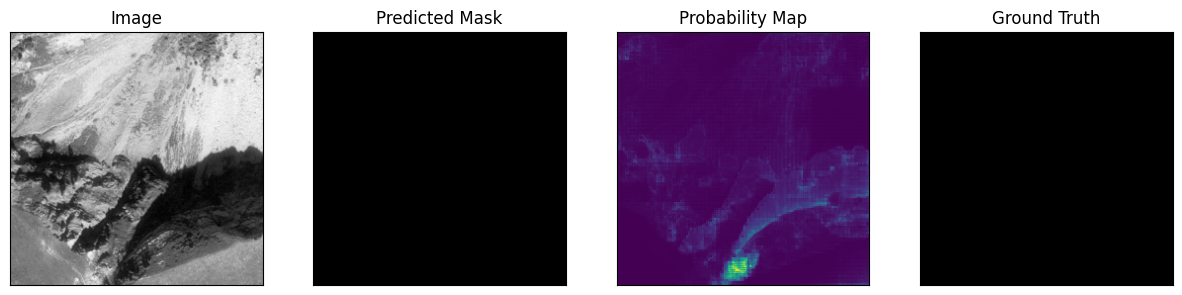

98
class  0  iou  1.0
98
class  1  iou  nan


In [ ]:
# let's take a random training example
idx = random.randint(0, filtered_test_images.shape[0]-1)

# load image
test_image = test_dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(test_dataset[idx]["label"])

prompt = get_bounding_box_image(np.array(test_image))
# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes = [[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()
num_classes = 3
# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.9).astype(np.uint8)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
cmap1 = plt.cm.colors.ListedColormap(['black', 'green'])
axes[1].imshow(medsam_seg, cmap=cmap1)  # Assuming the second image is grayscale
axes[1].set_title("Predicted Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")
cmap2 = plt.cm.colors.ListedColormap(['black', 'green','white'])
axes[3].imshow(ground_truth_mask,cmap= cmap2)  # Assuming the second image is grayscale
axes[3].set_title("Ground Truth")
# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
class_ious = [[] for _ in range(num_classes-1)]
valid_indices = np.where(ground_truth_mask != 2)

for class_id in range(num_classes-1):
    # Only consider valid indices for both ground_truth_mask and medsam_seg
    valid_ground_truth_mask = ground_truth_mask[valid_indices]
    valid_medsam_seg = medsam_seg[valid_indices]

    intersection = np.logical_and(valid_medsam_seg == class_id, valid_ground_truth_mask == class_id)
    union = np.logical_or(valid_medsam_seg == class_id, valid_ground_truth_mask == class_id)

    if np.sum(union) > 0:
        class_iou = np.sum(intersection) / np.sum(union)
    else:
        class_iou = np.nan

    class_ious[class_id].append(class_iou)
    print(idx)
    print("class ", class_id, " iou ", class_iou)

In [ ]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 339
})

In [ ]:
from torch.optim import Adam
import monai

#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
def iou(pred, target, cls, ignored_class = 2):
    ious = []
    pred_more_ratios = []
    pred_less_ratios = []

    for i in range(pred.shape[0]):
        iou_ratio, pred_more_ratio, pred_less_ratio = iou_one_image(pred[i], target[i], cls=cls, ignored_class=ignored_class)
        ious.append(iou_ratio)
        pred_more_ratios.append(pred_more_ratio)
        pred_less_ratios.append(pred_less_ratio)
        
    return np.array(ious), np.array(pred_more_ratios), np.array(pred_less_ratios)

In [ ]:
def calculate_accuracy(ground_truth, mask):
    # Ensure the shapes are the same
    assert ground_truth.shape == mask.shape, "Ground truth and mask must have the same shape"

    # Calculate accuracy
    correct_pixels = np.sum(ground_truth == mask)
    total_pixels = np.prod(ground_truth.shape)
    
    accuracy = correct_pixels / total_pixels

    return accuracy

In [36]:
num_classes = 3
test_accuracy = 0.0
test_loss = 0.0
test_ious = [0.0 for _ in range(num_classes-1)]
class_ious = [[] for _ in range(num_classes)]
all_tp, all_tn, all_fp, all_fn = [], [], [], []

for idx in range(filtered_test_images.shape[0]):

    # load image
    test_image = test_dataset[idx]["image"]
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(test_dataset[idx]["label"])
    #print(ground_truth_mask.shape)

    prompt = get_bounding_box_image(np.array(test_image))

    inputs = processor(test_image, input_boxes = [[prompt]], return_tensors="pt")
    
    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    my_mito_model.eval()
    # forward pass
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)

    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.7).astype(np.uint8)

    # Calculate accuracy and IoU per label
    accuracy = calculate_accuracy(ground_truth_mask,medsam_seg )
    test_accuracy+=accuracy
    #test_loss += loss
    valid_indices = np.where(ground_truth_mask != 2)

    for class_id in range(num_classes-1):
        # Only consider valid indices for both ground_truth_mask and medsam_seg
        valid_ground_truth_mask = ground_truth_mask[valid_indices]
        valid_medsam_seg = medsam_seg[valid_indices]

        intersection = np.logical_and(valid_medsam_seg == class_id, valid_ground_truth_mask == class_id)
        union = np.logical_or(valid_medsam_seg == class_id, valid_ground_truth_mask == class_id)

        if np.sum(union) > 0:
            class_iou = np.sum(intersection) / np.sum(union)
        else:
            class_iou = np.nan

        class_ious[class_id].append(class_iou)
    # Calculate TP, TN, FP, FN excluding "No Data" label
    tp = np.sum((medsam_seg == 1) & (ground_truth_mask == 1))
    tn = np.sum((medsam_seg == 0) & (ground_truth_mask == 0))
    fp = np.sum((medsam_seg == 1) & (ground_truth_mask == 0))
    fn = np.sum((medsam_seg == 0) & (ground_truth_mask == 1))

    all_tp.append(tp)
    all_tn.append(tn)
    all_fp.append(fp)
    all_fn.append(fn)

In [37]:
#mean_loss = mean(epoch_losses)
mean_accuracy = test_accuracy/filtered_test_images.shape[0]
mean_ious = [iou / filtered_test_images.shape[0] for iou in test_ious]
#print("mean loss:", mean_loss)  # e.g., (num_frames, height, width, num_channels)
print("mean accuracy:", mean_accuracy)
# Calculate average IoU for each class
iou_total = [0] * 2
iou_number = [0] * 2
for class_iou in range(2):
    for iou in class_ious[class_iou]:
        if(iou == np.nan):
            continue
        else:
            iou_total[class_iou] += iou
            iou_number[class_iou] +=1
            
print(iou_total[1]/iou_number[1])        
average_ious = [np.nanmean(class_iou) for class_iou in class_ious]

# Print or use the average IOUs as needed
for class_id, avg_iou in enumerate(average_ious):
    print(f'Class {class_id} Average IoU: {avg_iou}')

# Calculate overall TP, TN, FP, FN excluding "No Data" label
overall_tp = np.sum(all_tp)
overall_tn = np.sum(all_tn)
overall_fp = np.sum(all_fp)
overall_fn = np.sum(all_fn)

# Calculate precision, recall, and F1 score excluding "No Data" label
precision = overall_tp / (overall_tp + overall_fp)
recall = overall_tp / (overall_tp + overall_fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# print("Overall ROC AUC (excluding 'No Data' label):", overall_auc)
print("Overall TP:", overall_tp)
print("Overall TN:", overall_tn)
print("Overall FP:", overall_fp)
print("Overall FN:", overall_fn)
print("Precision (excluding 'No Data' label):", precision)
print("Recall (excluding 'No Data' label):", recall)
print("F1 Score (excluding 'No Data' label):", f1_score)

mean accuracy: 0.8397684913117626
nan
Class 0 Average IoU: 0.736686563546389
Class 1 Average IoU: 0.46110511730018194
Class 2 Average IoU: nan
Overall TP: 5475808
Overall TN: 13181080
Overall FP: 787461
Overall FN: 1436148
Precision (excluding 'No Data' label): 0.8742731631038041
Recall (excluding 'No Data' label): 0.7922226356765003
F1 Score (excluding 'No Data' label): 0.8312280055938324


/tmp/ipykernel_42/3463944714.py:18: RuntimeWarning: Mean of empty slice
  average_ious = [np.nanmean(class_iou) for class_iou in class_ious]
